# Предсказание рисков сердечного приступа

**Описание проекта**  

Необходимо проанализировать предоставленные данные пациентов и разработать модель машинного обучения, которая сможет предсказать риск сердечного приступа.

**Описание данных**  

- `id`  - уникальный идентификатор пациента
- антропометрические параметры (вес, возраст, рост)
- привычки (курение, качество сна и т.д)
- давление
- наличие хронических заболеваний
- биохимия крови
- целевой признак: высокий или низкий риск поражения сердца

<a id='content'></a>
**План работы** 

1. [Загрузка и изучение данных](#1_data_review)
2. [Предобработка данных](#2_preprocessing)
3. [Исследовательский анализ данных](#3_exploratory_analysis)
4. [Корреляционный анализ](#4_correlative_analysis)
5. [Добавление новых входных признаков](#5_new_features)  
6. [Обучение моделей](#6_model_training)  
7. [Предсказание на тестовой выборке](#7_predictions)  
8. [Итоговые выводы](#8_final)

In [1]:
!pip install catboost -q
!pip install phik -q
!pip install scikit-learn==1.4 -q
!pip install shap -q
!pip install xgboost -q

In [2]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import phik
import seaborn as sns
import shap

from catboost import CatBoostClassifier, Pool
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.metrics import (
    f1_score, 
    fbeta_score, 
    make_scorer, 
    recall_score, 
    roc_auc_score, 
    precision_recall_curve,
    precision_score
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [3]:
pd.set_option('display.max_columns', None) 

<a id='1_data_review'></a>
## Загрузка и изучение данных

### Загрузка данных

In [4]:
# загружаем данные из csv-файлов
filenames = ['heart_train.csv', 'heart_test.csv']
dfs = {}
path = '../datasets/'
missing_files = []

read_params = {
    'heart_train.csv': {'sep': ',', 'decimal': '.', 'index_col': 'id'},
    'heart_test.csv': {'sep': ',', 'decimal': '.', 'index_col': 'id'},
}

for filename in filenames:
    full_path = os.path.join(path, filename)
    if os.path.exists(full_path):
        dfs[filename] = pd.read_csv(full_path, **read_params[filename])
    elif os.path.exists(filename):
        dfs[filename] = pd.read_csv(filename, **read_params[filename])
    else:
        missing_files.append(filename)

if missing_files:
    raise FileNotFoundError(f"Не удалось найти файлы: {', '.join(missing_files)}")
        
# сохраняем их в датафреймы
heart_train = dfs['heart_train.csv']
heart_test = dfs['heart_test.csv']

### Изучение данных

In [5]:
# функция для вывода основных характеристик датафреймов
def analyze_dataframe(
    df, 
    label=None, 
    show_head=True, 
    show_info=True, 
    show_describe=True, 
    show_duplicates=True, 
    show_na=True
):
    print('=' * 80)
    if label:
        print(f'Анализ датафрейма: {label}')
    else:
        print('Анализ датафрейма:')
    print('=' * 80)
    
    if show_head:
        print('\n--- Head ---')
        display(df.head())

    if show_info:
        print('\n--- Info ---')
        df.info()

    if show_describe:
        print('\n--- Describe ---')
        display(df.describe(include='all'))

    if show_duplicates:
        print(f'\n--- Duplicates --- \n{df.duplicated().sum()}')

    if show_na:
        print('\n--- Null Values ---')
        print(df.isna().sum())

In [6]:
# выводим общую информацию о датафреймах heart_train, heart_test
for name, df in [
    ('heart_train', heart_train),
    ('heart_test', heart_test),
]:
    analyze_dataframe(df, label=name)

Анализ датафрейма: heart_train

--- Head ---


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
2664,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302
9287,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767
5379,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930
8222,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442
4047,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860



--- Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 2664 to 7270
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medicati

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
count,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685,8685.000000,8685.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5882,NaN,NaN
mean,4342.000000,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,1.057455,0.495380,0.501185,5.493367,0.499164,0.496055,0.496774,0.505484,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,NaN,0.450295,0.497634
std,2507.287877,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,0.866645,0.500008,0.500028,2.867862,0.285340,0.284698,0.282561,0.286320,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,NaN,0.170184,0.171830
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
25%,2171.000000,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,0.000000,0.000000,3.000000,0.255875,0.251922,0.254190,0.263636,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,NaN,0.303226,0.348837
50%,4342.000000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,0.000000,1.000000,5.000000,0.499920,0.494889,0.494774,0.503603,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,NaN,0.445161,0.500000
75%,6513.000000,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,1.000000,1.000000,8.000000,0.744623,0.741036,0.736974,0.750649,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,NaN,0.600000,0.651163



--- Duplicates --- 
0

--- Null Values ---
Unnamed: 0                           0
Age                                  0
Cholesterol                          0
Heart rate                           0
Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Exercise Hours Per Week              0
Diet                                 0
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Sedentary Hours Per Day              0
Income                               0
BMI                                  0
Triglycerides                        0
Physical Activity Days Per Week    243
Sleep Hours Per Day                  0
Heart Attack Risk (Binary)           0
Blood sugar                          0
CK-MB                                0
Troponin                             0
Gender              

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
7746,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093
4202,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860
6632,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070
4639,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814
4825,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349



--- Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 7746 to 6521
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medicatio

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
count,966.00000,966.000000,966.000000,966.000000,935.000000,935.000000,935.000000,935.000000,935.000000,966.000000,966.000000,935.000000,935.000000,935.000000,966.000000,966.000000,966.000000,966.000000,935.000000,966.000000,966.000000,966.000000,966.000000,966,966.000000,966.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,650,NaN,NaN
mean,482.50000,0.452916,0.488181,0.051644,0.656684,0.481283,0.898396,0.516578,0.583957,0.490706,1.053830,0.494118,0.488770,5.332620,0.506715,0.484408,0.476796,0.486688,3.443850,0.512571,0.224127,0.048855,0.034926,NaN,0.447172,0.496822
std,279.00448,0.231068,0.282039,0.035502,0.475070,0.499917,0.302289,0.499993,0.493165,0.284902,0.884642,0.500233,0.500141,2.858466,0.287826,0.273879,0.291987,0.284534,2.302778,0.322292,0.065270,0.079742,0.053855,NaN,0.171837,0.173935
min,0.00000,0.044944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,0.000000,0.000000,1.000000,0.001187,0.003351,0.002598,0.000000,0.000000,0.000000,0.029644,0.000000,0.000194,NaN,0.012903,0.116279
25%,241.25000,0.247191,0.243750,0.036664,0.000000,0.000000,1.000000,0.000000,0.000000,0.243431,0.000000,0.000000,0.000000,3.000000,0.258713,0.261446,0.217527,0.249675,1.000000,0.166667,0.227018,0.048229,0.036512,NaN,0.296774,0.348837
50%,482.50000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,1.000000,1.000000,0.502110,1.000000,0.000000,0.000000,5.000000,0.501327,0.492015,0.471185,0.488961,3.000000,0.500000,0.227018,0.048229,0.036512,NaN,0.445161,0.488372
75%,723.75000,0.640449,0.710714,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.734425,2.000000,1.000000,1.000000,8.000000,0.759591,0.705371,0.720503,0.718182,5.000000,0.833333,0.227018,0.048229,0.036512,NaN,0.600000,0.639535



--- Duplicates --- 
0

--- Null Values ---
Unnamed: 0                          0
Age                                 0
Cholesterol                         0
Heart rate                          0
Diabetes                           31
Family History                     31
Smoking                            31
Obesity                            31
Alcohol Consumption                31
Exercise Hours Per Week             0
Diet                                0
Previous Heart Problems            31
Medication Use                     31
Stress Level                       31
Sedentary Hours Per Day             0
Income                              0
BMI                                 0
Triglycerides                       0
Physical Activity Days Per Week    31
Sleep Hours Per Day                 0
Blood sugar                         0
CK-MB                               0
Troponin                            0
Gender                              0
Systolic blood pressure             0
Diasto

📌 **Предварительный обзор данных:**  

*1. Общая структура данных*
- `heart_train`: 8685 строк, 27 столбцов; `heart_test`: 966 строк, 26 столбцов
- целевой признак `Heart Attack Risk (Binary)` присутствует только в тренировочной выборке (как и указано в ТЗ)

*2. Особенности признаков*
- признаки в основном числовые (`float64`, `int64`), есть один категориальный (`Gender`)
- тип данных большинства числовых столбцов - `float64`, при этом, часть признаков является дискретными (например, `Diabetes`, `Family History`, `Smoking`), и логично было бы привести их к целочисленному типу, однако учитывая, что в этих колонках содержатся пропуски (т.е. стандартные целочисленные типы использовать нельзя), а при обучении модели все признаки будут преобразованы обратно к `float64`, явное изменение типа данных на этапе предобработки не требуется
- столбец `Unnamed: 0`, судя по всему, служебный (нумерация строк) - его стоит удалить
- диапазоны числовых признаков выглядят нормированными (0–1 или близко к этому), но встречаются значения = 0, которые для некоторых медицинских параметров выглядят подозрительно (например, `Age`, `Heart rate`)
- встречаются проблемы в названиях столбцов (пробелы, скобки, разные регистры) - для упрощения работы с признаками следует привести всё к единому стилю

*3. Дубликаты*
- строк-дубликатов нет в обеих выборках
- категориальный признак `Gender` следует проверить на неявные дубликаты

*4. Пропуски*
- в обоих датасетах есть пропуски в одних и тех же признаках: `Diabetes`, `Family History`, `Smoking`, `Obesity`, `Alcohol Consumption`, `Previous Heart Problems`, `Medication Use`, `Stress Level`, `Physical Activity Days Per Week`
- предположительно, пропуски в перечисленных признаках находятся в одних и тех же строках (судя по количеству строк)
- количество пропусков: train - 243 (≈ 2.8% от выборки), test - 31 (≈ 3.2%)

**Итог:** данные требуют обязательной предобработки для дальнейшего корректного анализа и обучения моделей

<a id='2_preprocessing'></a>
## Предобработка данных

### Удаление служебных столбцов

In [7]:
# удалим лишние столбцы из тренировочной и тестовой выборок
for df in [
    ('heart_train', heart_train),
    ('heart_test', heart_test),
]:
    df[1].drop(['Unnamed: 0'], axis=1, inplace=True)

### Переименование столбцов

In [8]:
# переименуем столбцы в тренировочной и тестовой выборках
for df in [
    ('heart_train', heart_train),
    ('heart_test', heart_test),
]:
    df[1].rename(columns={
        'Age' : 'age', 
        'Cholesterol' : 'cholesterol', 
        'Heart rate' : 'heart_rate', 
        'Diabetes' : 'diabetes',
        'Family History' : 'family_history',
        'Smoking' : 'smoking',
        'Obesity' : 'obesity', 
        'Alcohol Consumption' : 'alcohol',
        'Exercise Hours Per Week' : 'exercise_hrs_week',
        'Diet' : 'diet_type',
        'Previous Heart Problems' : 'prev_heart_problems',
        'Medication Use' : 'medication',
        'Stress Level' : 'stress_level',
        'Sedentary Hours Per Day' : 'sedentary_hrs_day',
        'Income' : 'income',
        'BMI' : 'body_mass_idx',
        'Triglycerides' : 'triglycerides',
        'Physical Activity Days Per Week' : 'physical_activity_days_week',
        'Sleep Hours Per Day' : 'sleep_hrs_day',
        'Blood sugar' : 'blood_sugar',
        'CK-MB' : 'ck-mb',
        'Troponin' : 'troponin',
        'Gender' : 'gender',
        'Systolic blood pressure' : 'systolic_blood_pressure',
        'Diastolic blood pressure' : 'diastolic_blood_pressure',
    }, inplace=True)
    
heart_train.rename(columns={
    'Heart Attack Risk (Binary)' : 'heart_attack_risk'
}, inplace=True)

### Обработка пропусков

In [9]:
# выведем числовое описание строк, содержащих пропуски, в тренировочной выборке 
heart_train.loc[heart_train['diabetes'].isna()].describe(include='all')

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol,exercise_hrs_week,diet_type,prev_heart_problems,medication,stress_level,sedentary_hrs_day,income,body_mass_idx,triglycerides,physical_activity_days_week,sleep_hrs_day,heart_attack_risk,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
count,243.000000,243.00000,243.000000,0.0,0.0,0.0,0.0,0.0,243.00000,243.0,0.0,0.0,0.0,2.430000e+02,2.430000e+02,2.430000e+02,2.430000e+02,0.0,2.430000e+02,243.0,243.000000,243.000000,243.000000,243,243.000000,243.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,NaN,NaN
mean,0.482961,0.49978,0.066760,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,NaN,NaN,NaN,4.999199e-01,4.948894e-01,4.947741e-01,5.036030e-01,NaN,5.046212e-01,0.0,0.204436,0.062550,0.030492,NaN,0.392646,0.357355
std,0.161522,0.00000,0.087221,NaN,NaN,NaN,NaN,NaN,0.00000,0.0,NaN,NaN,NaN,5.562573e-17,2.225029e-16,1.112515e-16,2.225029e-16,NaN,1.112515e-16,0.0,0.126380,0.177867,0.085016,NaN,0.160063,0.165995
min,0.000000,0.49978,0.000000,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,NaN,NaN,NaN,4.999199e-01,4.948894e-01,4.947741e-01,5.036030e-01,NaN,5.046212e-01,0.0,0.029644,0.000107,0.000194,NaN,0.000000,0.000000
25%,0.370787,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,NaN,NaN,NaN,4.999199e-01,4.948894e-01,4.947741e-01,5.036030e-01,NaN,5.046212e-01,0.0,0.120553,0.004418,0.000485,NaN,0.283871,0.232558
50%,0.516854,0.49978,0.056829,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,NaN,NaN,NaN,4.999199e-01,4.948894e-01,4.947741e-01,5.036030e-01,NaN,5.046212e-01,0.0,0.156126,0.008673,0.001262,NaN,0.354839,0.360465
75%,0.578652,0.49978,0.069661,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,NaN,NaN,NaN,4.999199e-01,4.948894e-01,4.947741e-01,5.036030e-01,NaN,5.046212e-01,0.0,0.246047,0.021770,0.006311,NaN,0.480645,0.453488


Как видно из числового описания, пропущенные значения в нескольких столбцах `('diabetes', 'family_history', 'smoking', 'obesity', 'alcohol', 'prev_heart_problems', 'medication', 'stress_level', 'physical_activity_days_week')` действительно находятся в одних и тех же строках. Интересно также, что в части остальных столбцов `('cholesterol', 'exercise_hrs_week', 'diet_type', 'sedentary_hrs_day', 'income', 'body_mass_idx', 'triglycerides', 'sleep_hrs_day')` эти строки заполнены средним значением.

Такие строки, скорее всего, образовались в результате объединения данных из разных источников, где для части пациентов отсутствовали анкетные сведения, но имелись лабораторные анализы и при подготовке данных (масштабировании/кодировании) недостающие признаки автоматически заполнились средними значениями.

Поскольку эти строки лишены содержательных факторов риска и при этом заполнены средними значениями по ряду других признаков, они не несут полезной информации для модели и могут исказить распределения; кроме того, их доля в выборке невелика (≈ 2.8%), поэтому такие строки целесообразно удалить.

In [10]:
# выведем также описание пропусков в тестовой выборке 
heart_test.loc[heart_test['diabetes'].isna()].describe(include='all')

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol,exercise_hrs_week,diet_type,prev_heart_problems,medication,stress_level,sedentary_hrs_day,income,body_mass_idx,triglycerides,physical_activity_days_week,sleep_hrs_day,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
count,31.000000,3.100000e+01,31.000000,0.0,0.0,0.0,0.0,0.0,31.00000,31.0,0.0,0.0,0.0,3.100000e+01,3.100000e+01,3.100000e+01,3.100000e+01,0.0,3.100000e+01,31.000000,31.000000,31.000000,31,31.000000,31.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,NaN,NaN
mean,0.477347,4.997802e-01,0.082404,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,NaN,NaN,NaN,4.999199e-01,4.948894e-01,4.947741e-01,5.036030e-01,NaN,5.046212e-01,0.171363,0.044163,0.040903,NaN,0.370239,0.378095
std,0.118089,1.128575e-16,0.171493,NaN,NaN,NaN,NaN,NaN,0.00000,0.0,NaN,NaN,NaN,1.128575e-16,1.128575e-16,2.257150e-16,1.128575e-16,NaN,1.128575e-16,0.086802,0.177802,0.174275,NaN,0.152743,0.153261
min,0.280899,4.997802e-01,0.000000,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,NaN,NaN,NaN,4.999199e-01,4.948894e-01,4.947741e-01,5.036030e-01,NaN,5.046212e-01,0.061265,0.001548,0.000194,NaN,0.012903,0.116279
25%,0.359551,4.997802e-01,0.038955,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,NaN,NaN,NaN,4.999199e-01,4.948894e-01,4.947741e-01,5.036030e-01,NaN,5.046212e-01,0.124506,0.006070,0.000583,NaN,0.300000,0.296512
50%,0.483146,4.997802e-01,0.048579,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,NaN,NaN,NaN,4.999199e-01,4.948894e-01,4.947741e-01,5.036030e-01,NaN,5.046212e-01,0.144269,0.009740,0.001068,NaN,0.380645,0.337209
75%,0.578652,4.997802e-01,0.063703,NaN,NaN,NaN,NaN,NaN,0.50211,3.0,NaN,NaN,NaN,4.999199e-01,4.948894e-01,4.947741e-01,5.036030e-01,NaN,5.046212e-01,0.203557,0.014412,0.004612,NaN,0.429032,0.476744


Аналогичная ситуация в тестовой выборке: те же столбцы с пропусками, те же столбцы заполнены средним, что и в тренировочной выборке. Доля пропусков в тестовой выборке также невелика (≈ 3.2%) - полагаю, для согласованности предобработки данных train и test, нужно удалить строки с пропусками в обеих выборках.

In [11]:
# удалим строки с NaN из train и test
heart_train.dropna(subset=['diabetes'], inplace=True)
heart_test.dropna(subset=['diabetes'], inplace=True)

### Обработка дубликатов

In [12]:
# проверим столбец gender на неявные дубликаты
for name,df in [
    ('heart_train', heart_train),
    ('heart_test', heart_test),
]:
    print(f'Unique values in {name}:', df['gender'].unique())

Unique values in heart_train: ['Male' 'Female']
Unique values in heart_test: ['Male' 'Female']


В датасете бинарный признак пола (`Gender`) представлен строками `('Male', 'Female')`. Для единообразия данных значения следует привести к числовому формату. Поскольку по остальным признакам в датасете затруднительно однозначно идентифицировать пол, используем общепринятое медицинское кодирование: `0 = Female`, `1 = Male`.

In [13]:
# приведем gender к единому формату: 0 = Female, 1 = Male
for name,df in [
    ('heart_train', heart_train),
    ('heart_test', heart_test),
]:
    df['gender'] = df['gender'].map({'Female': 0, 'Male': 1,}).astype(int)
    print(f'Unique values in {name}:', df['gender'].unique().tolist())

Unique values in heart_train: [1, 0]
Unique values in heart_test: [1, 0]


📌 **Итоговые выводы по разделу:**  
- на этапе предобработки данных были проведены следующие преобразования:
    - из тренировочной и тестовой выборки был удален служебный столбец `Unnamed: 0` (нумерация строк)
    - все названия столбцов были приведены к единому стилю (snake case, без пробелов)
    - строки, содержащие пропуски, удалены
    - категории в столбце `gender` были приведены к числовому формату
- явное преобразование типа данных не было выполнено - дискретные признаки оставлены с типом `float64`, чтобы избежать лишних преобразований, поскольку в дальнейшем, в процессе обучения моделей, данные всё равно будут приведены к этому типу

**Итог:** данные предобработаны и готовы к исследовательскому анализу

<a id='3_exploratory_analysis'></a>
## Исследовательский анализ данных

In [14]:
# функция для вывода характеристик и построения графиков для количественных признаков
def eda_numeric(df, col, label='', bins=50, kde=True, threshold=10):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # числовое описание
    print(f'Анализ количественного признака {col}')
    print(df[col].describe())
    print('*' * 40)

    # настройки области графика
    sns.set_theme(style='darkgrid', rc={'figure.figsize': (8,4)})
    sns.set_palette('Set2')

    # подсчёт количества уникальных значений
    unique_vals = df[col].nunique(dropna=False)

    if unique_vals <= threshold and pd.api.types.is_numeric_dtype(df[col]):
        # дискретный числовой признак
        print(f"Признак '{col}' определён как дискретный (уникальных значений: {unique_vals})")
        ax = sns.countplot(x=col, data=df)
        
        # округление меток оси х и проверка длины
        ax.set_xticks(ax.get_xticks())
        new_labels = []
        for tick in ax.get_xticklabels():
            try:
                new_labels.append(f'{float(tick.get_text()):.1f}')
            except ValueError:
                new_labels.append(tick.get_text())
        
        # поворот слишком длинных подписей
        rotate_angle = 90 if any(len(lbl) > 6 for lbl in new_labels) else 0
        ax.set_xticklabels(new_labels, rotation=rotate_angle)
        
        plt.title(f'Столбчатая диаграмма частот признака {col}')
        plt.xlabel(label if label else col)
        plt.ylabel('Количество наблюдений')
        plt.tight_layout()
        plt.show()

    else:
        # непрерывный числовой признак
        print(f"Признак '{col}' определён как непрерывный (уникальных значений: {unique_vals})")
        f, (ax_box, ax_hist) = plt.subplots(
            2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)}
        )
        sns.boxplot(x=df[col], ax=ax_box, orient='h')
        sns.histplot(df[col], bins=bins, kde=kde, ax=ax_hist)
        ax_box.set_title(f'Диаграмма размаха признака {col}')
        ax_box.set(xlabel='', ylabel='')
        ax_hist.set_title(f'Гистограмма признака {col}')
        ax_hist.set(xlabel=label if label else col, ylabel='количество наблюдений')
        plt.tight_layout()
        plt.show()
        
# список количественных признаков для анализа                
num_columns = [
    col for col in heart_train.columns if heart_train[col].dtype != 'object'
]

Анализ количественного признака age
count    8442.000000
mean        0.449008
std         0.232809
min         0.044944
25%         0.247191
50%         0.460674
75%         0.640449
max         0.853933
Name: age, dtype: float64
****************************************
Признак 'age' определён как непрерывный (уникальных значений: 73)


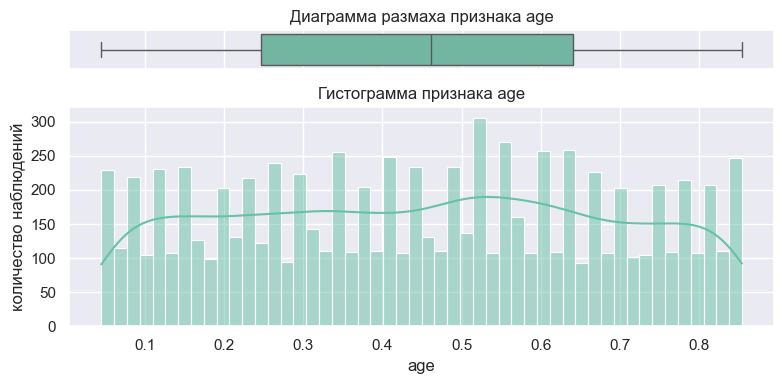

Анализ количественного признака cholesterol
count    8442.000000
mean        0.501108
std         0.288785
min         0.000000
25%         0.260714
50%         0.496429
75%         0.750000
max         1.000000
Name: cholesterol, dtype: float64
****************************************
Признак 'cholesterol' определён как непрерывный (уникальных значений: 281)


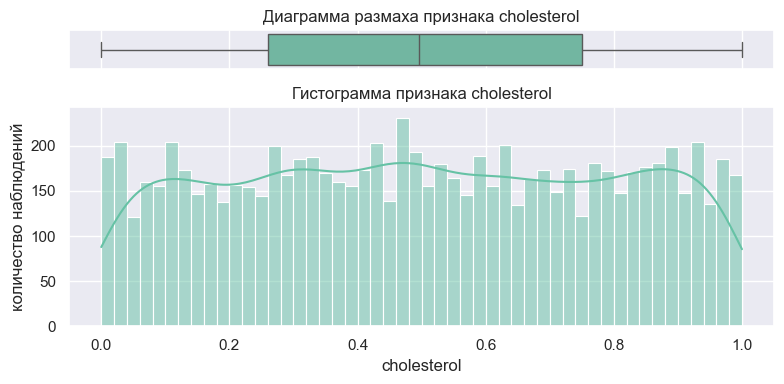

Анализ количественного признака heart_rate
count    8442.000000
mean        0.050194
std         0.018442
min         0.018332
25%         0.034830
50%         0.050412
75%         0.065995
max         0.082493
Name: heart_rate, dtype: float64
****************************************
Признак 'heart_rate' определён как непрерывный (уникальных значений: 71)


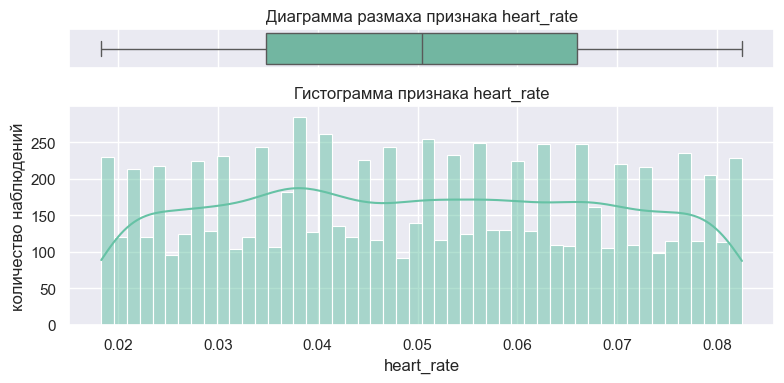

Анализ количественного признака diabetes
count    8442.000000
mean        0.652097
std         0.476333
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: diabetes, dtype: float64
****************************************
Признак 'diabetes' определён как дискретный (уникальных значений: 2)


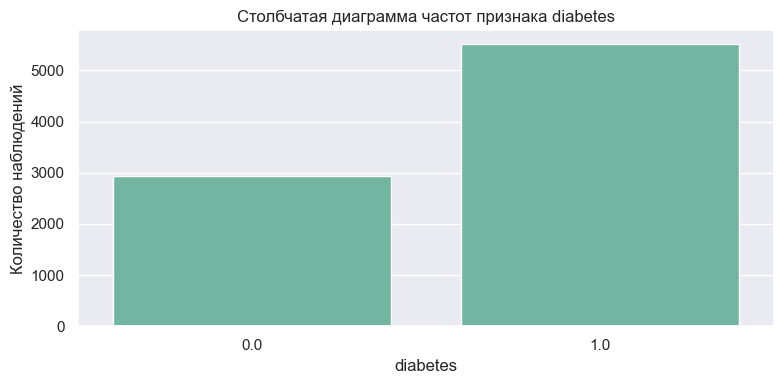

Анализ количественного признака family_history
count    8442.000000
mean        0.489576
std         0.499921
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: family_history, dtype: float64
****************************************
Признак 'family_history' определён как дискретный (уникальных значений: 2)


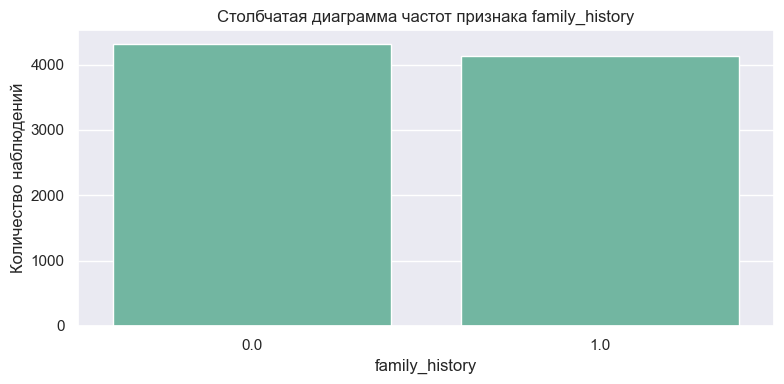

Анализ количественного признака smoking
count    8442.000000
mean        0.902867
std         0.296157
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: smoking, dtype: float64
****************************************
Признак 'smoking' определён как дискретный (уникальных значений: 2)


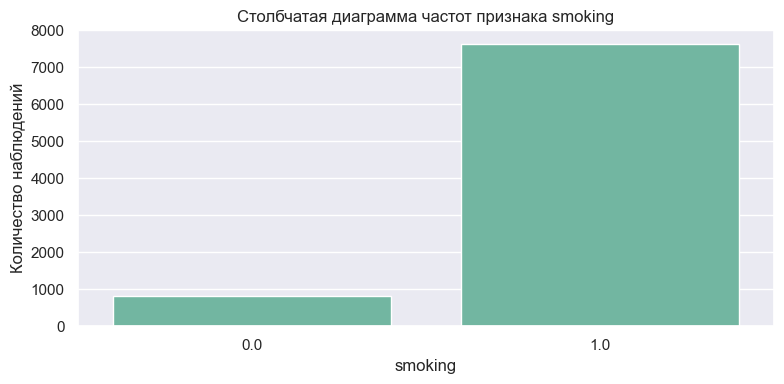

Анализ количественного признака obesity
count    8442.000000
mean        0.498342
std         0.500027
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: obesity, dtype: float64
****************************************
Признак 'obesity' определён как дискретный (уникальных значений: 2)


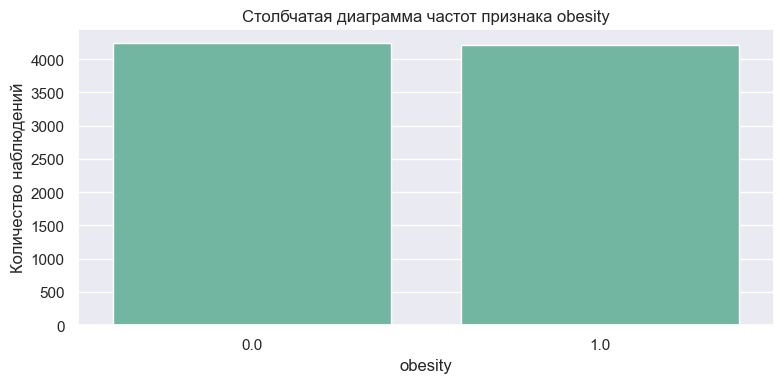

Анализ количественного признака alcohol
count    8442.000000
mean        0.601990
std         0.489517
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: alcohol, dtype: float64
****************************************
Признак 'alcohol' определён как дискретный (уникальных значений: 2)


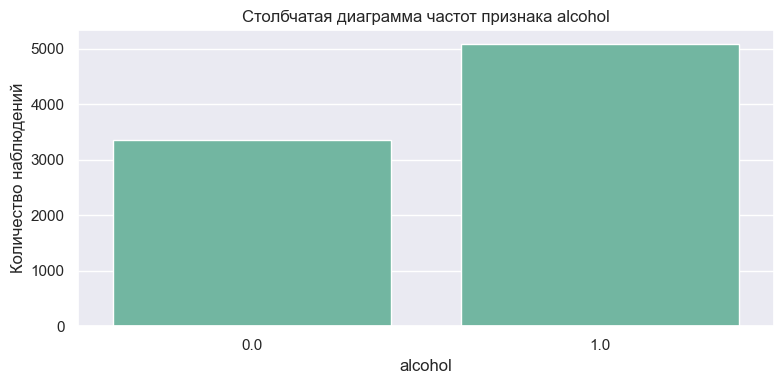

Анализ количественного признака exercise_hrs_week
count    8442.000000
mean        0.503415
std         0.288881
min         0.000000
25%         0.253359
50%         0.508244
75%         0.754901
max         1.000000
Name: exercise_hrs_week, dtype: float64
****************************************
Признак 'exercise_hrs_week' определён как непрерывный (уникальных значений: 7932)


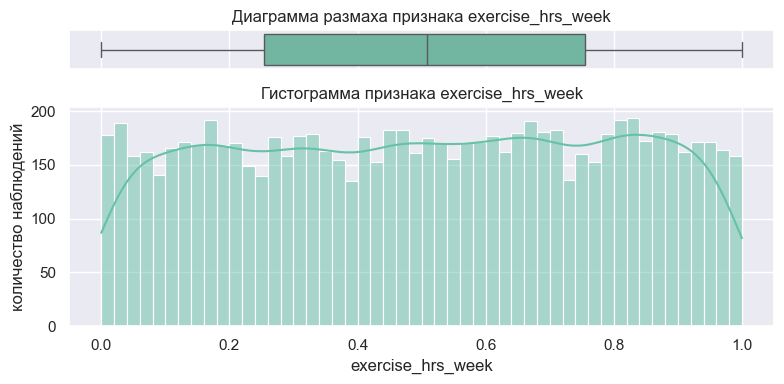

Анализ количественного признака diet_type
count    8442.000000
mean        1.001540
std         0.812981
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: diet_type, dtype: float64
****************************************
Признак 'diet_type' определён как дискретный (уникальных значений: 3)


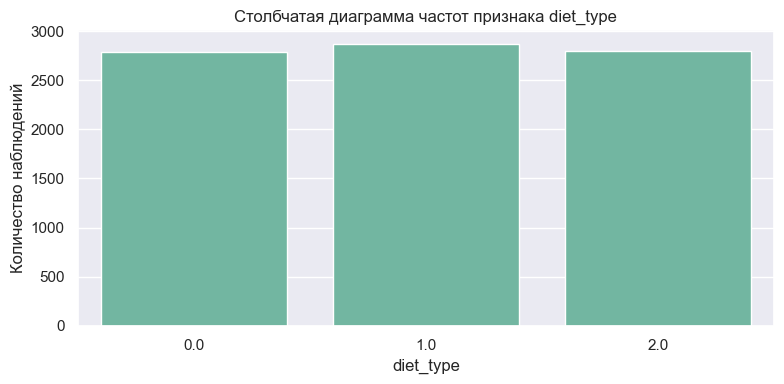

Анализ количественного признака prev_heart_problems
count    8442.000000
mean        0.495380
std         0.500008
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: prev_heart_problems, dtype: float64
****************************************
Признак 'prev_heart_problems' определён как дискретный (уникальных значений: 2)


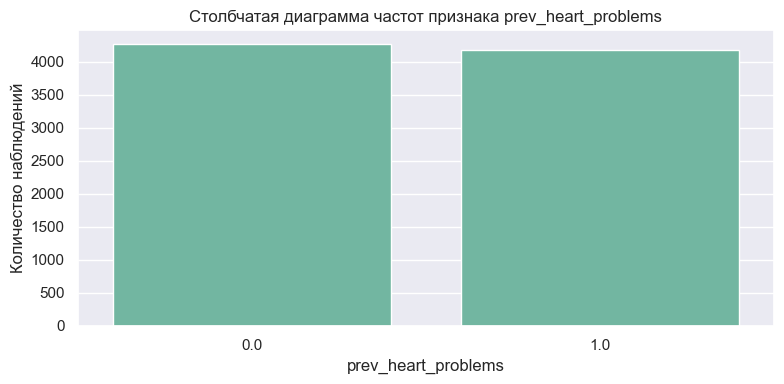

Анализ количественного признака medication
count    8442.000000
mean        0.501185
std         0.500028
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: medication, dtype: float64
****************************************
Признак 'medication' определён как дискретный (уникальных значений: 2)


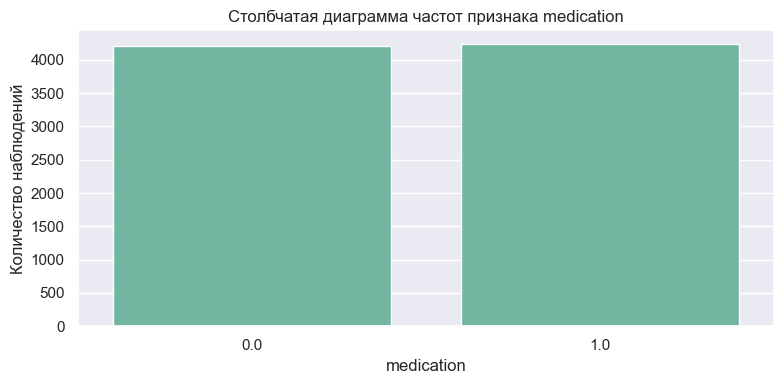

Анализ количественного признака stress_level
count    8442.000000
mean        5.493367
std         2.867862
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: stress_level, dtype: float64
****************************************
Признак 'stress_level' определён как дискретный (уникальных значений: 10)


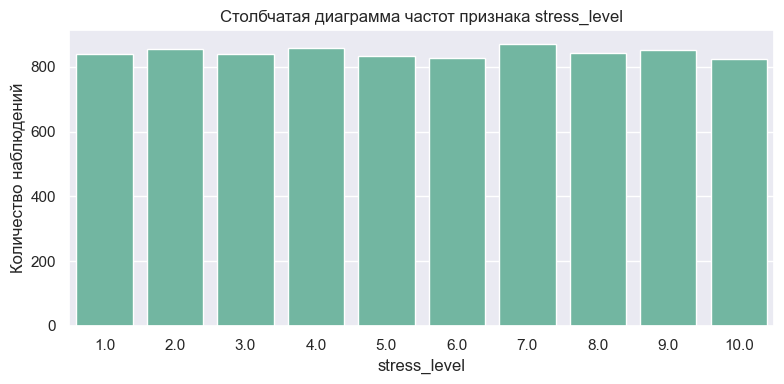

Анализ количественного признака sedentary_hrs_day
count    8442.000000
mean        0.499142
std         0.289418
min         0.000000
25%         0.247650
50%         0.492734
75%         0.751047
max         1.000000
Name: sedentary_hrs_day, dtype: float64
****************************************
Признак 'sedentary_hrs_day' определён как непрерывный (уникальных значений: 7932)


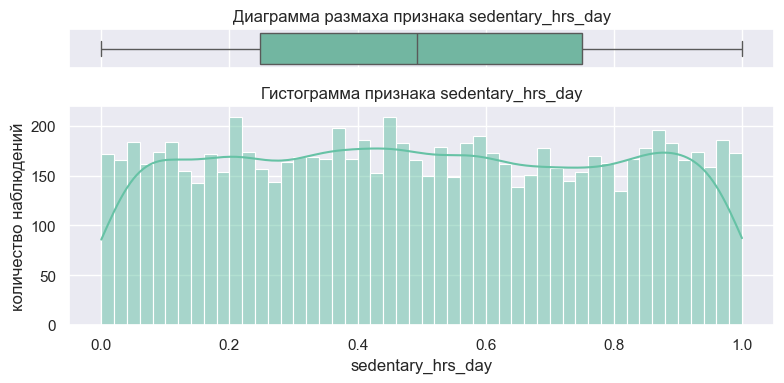

Анализ количественного признака income
count    8442.000000
mean        0.496089
std         0.288767
min         0.000000
25%         0.244591
50%         0.496052
75%         0.747603
max         1.000000
Name: income, dtype: float64
****************************************
Признак 'income' определён как непрерывный (уникальных значений: 7807)


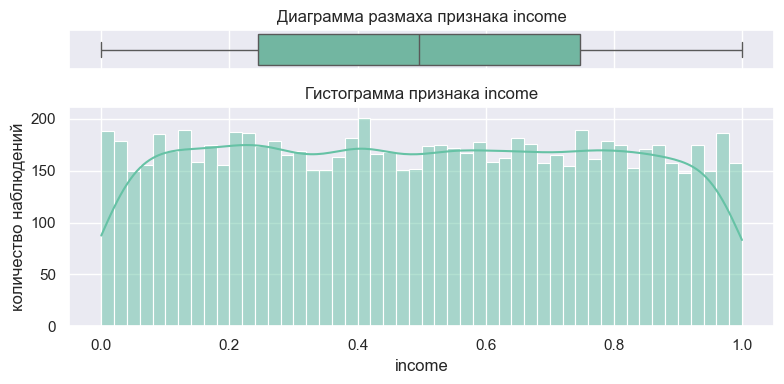

Анализ количественного признака body_mass_idx
count    8442.000000
mean        0.496831
std         0.286599
min         0.000000
25%         0.247935
50%         0.490801
75%         0.744399
max         1.000000
Name: body_mass_idx, dtype: float64
****************************************
Признак 'body_mass_idx' определён как непрерывный (уникальных значений: 7932)


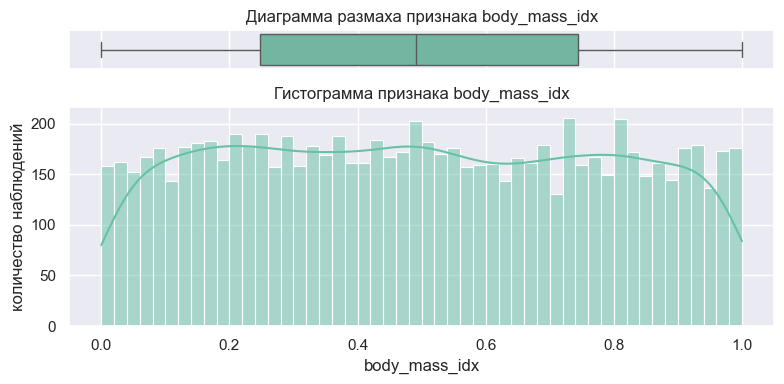

Анализ количественного признака triglycerides
count    8442.000000
mean        0.505539
std         0.290412
min         0.000000
25%         0.257143
50%         0.507792
75%         0.758442
max         1.000000
Name: triglycerides, dtype: float64
****************************************
Признак 'triglycerides' определён как непрерывный (уникальных значений: 771)


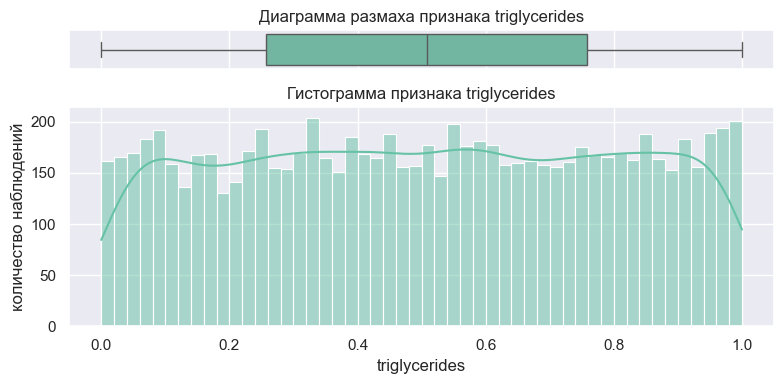

Анализ количественного признака physical_activity_days_week
count    8442.000000
mean        3.508292
std         2.281772
min         0.000000
25%         2.000000
50%         3.000000
75%         6.000000
max         7.000000
Name: physical_activity_days_week, dtype: float64
****************************************
Признак 'physical_activity_days_week' определён как дискретный (уникальных значений: 8)


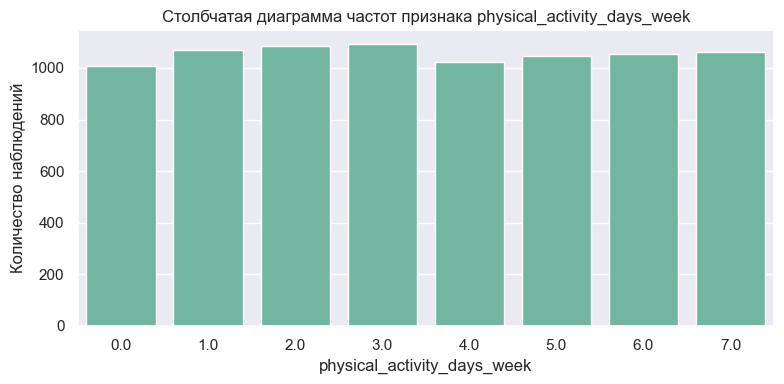

Анализ количественного признака sleep_hrs_day
count    8442.000000
mean        0.503712
std         0.332749
min         0.000000
25%         0.166667
50%         0.500000
75%         0.833333
max         1.000000
Name: sleep_hrs_day, dtype: float64
****************************************
Признак 'sleep_hrs_day' определён как дискретный (уникальных значений: 7)


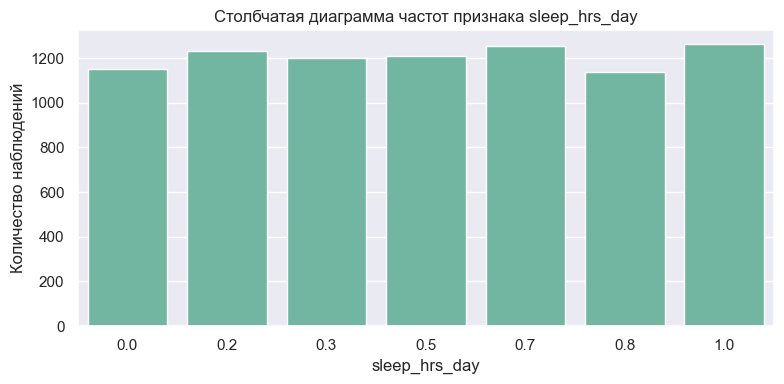

Анализ количественного признака heart_attack_risk
count    8442.000000
mean        0.356906
std         0.479115
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: heart_attack_risk, dtype: float64
****************************************
Признак 'heart_attack_risk' определён как дискретный (уникальных значений: 2)


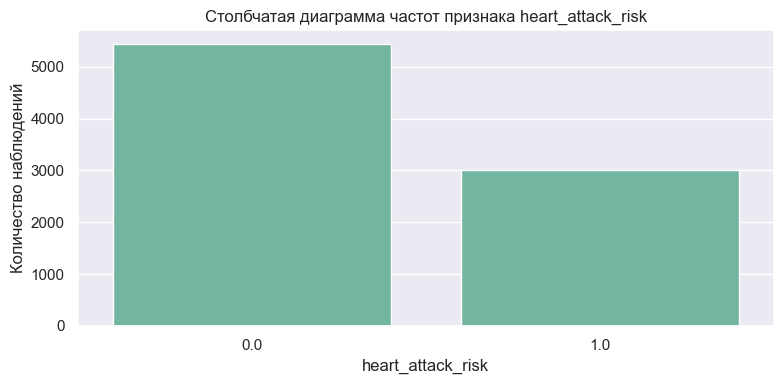

Анализ количественного признака blood_sugar
count    8442.000000
mean        0.227998
std         0.074623
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: blood_sugar, dtype: float64
****************************************
Признак 'blood_sugar' определён как непрерывный (уникальных значений: 224)


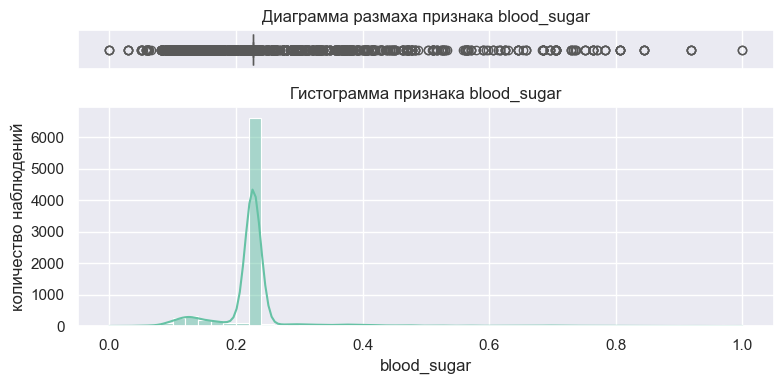

Анализ количественного признака ck-mb
count    8442.000000
mean        0.047745
std         0.070399
min         0.000000
25%         0.048229
50%         0.048229
75%         0.048229
max         1.000000
Name: ck-mb, dtype: float64
****************************************
Признак 'ck-mb' определён как непрерывный (уникальных значений: 588)


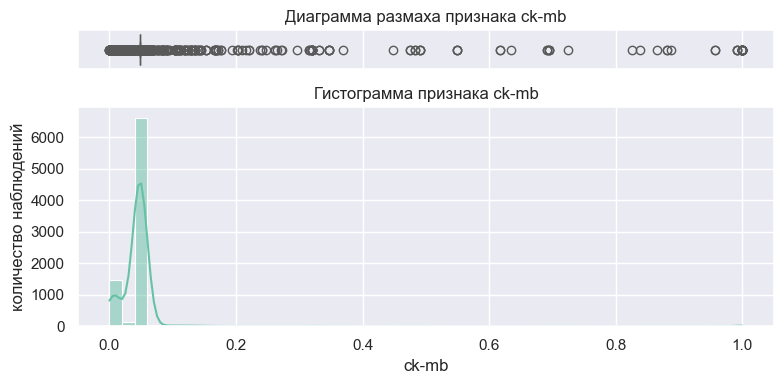

Анализ количественного признака troponin
count    8442.000000
mean        0.036867
std         0.059284
min         0.000000
25%         0.036512
50%         0.036512
75%         0.036512
max         1.000000
Name: troponin, dtype: float64
****************************************
Признак 'troponin' определён как непрерывный (уникальных значений: 298)


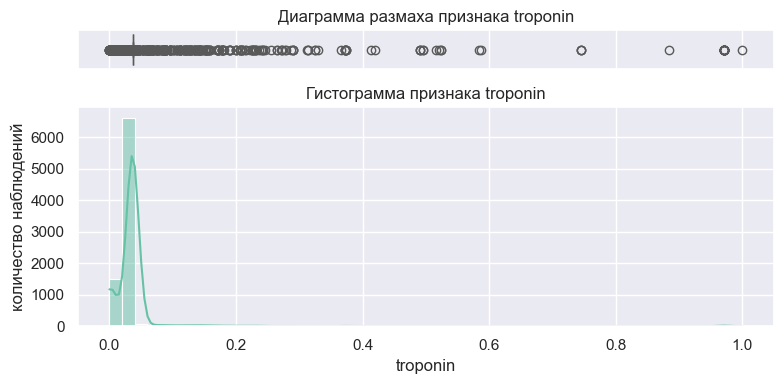

Анализ количественного признака gender
count    8442.000000
mean        0.696754
std         0.459688
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64
****************************************
Признак 'gender' определён как дискретный (уникальных значений: 2)


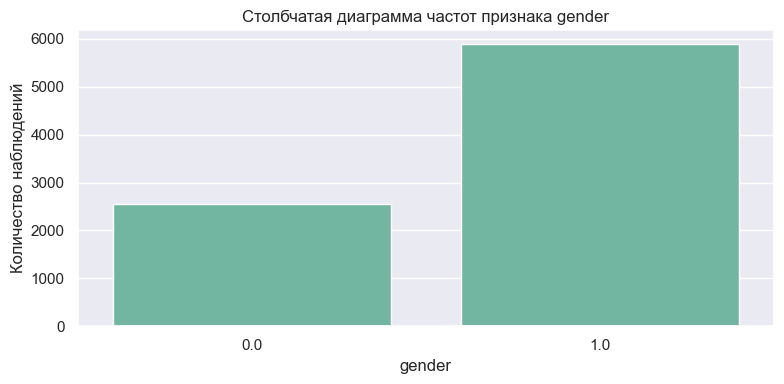

Анализ количественного признака systolic_blood_pressure
count    8442.000000
mean        0.451955
std         0.170187
min         0.161290
25%         0.303226
50%         0.451613
75%         0.600000
max         0.741935
Name: systolic_blood_pressure, dtype: float64
****************************************
Признак 'systolic_blood_pressure' определён как непрерывный (уникальных значений: 91)


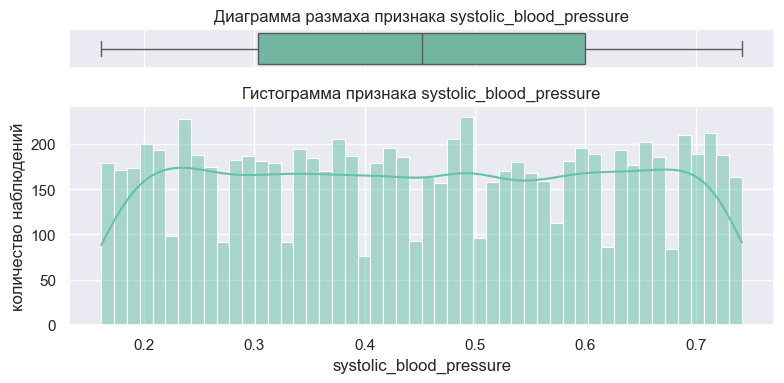

Анализ количественного признака diastolic_blood_pressure
count    8442.000000
mean        0.501672
std         0.170302
min         0.209302
25%         0.348837
50%         0.500000
75%         0.651163
max         0.790698
Name: diastolic_blood_pressure, dtype: float64
****************************************
Признак 'diastolic_blood_pressure' определён как непрерывный (уникальных значений: 51)


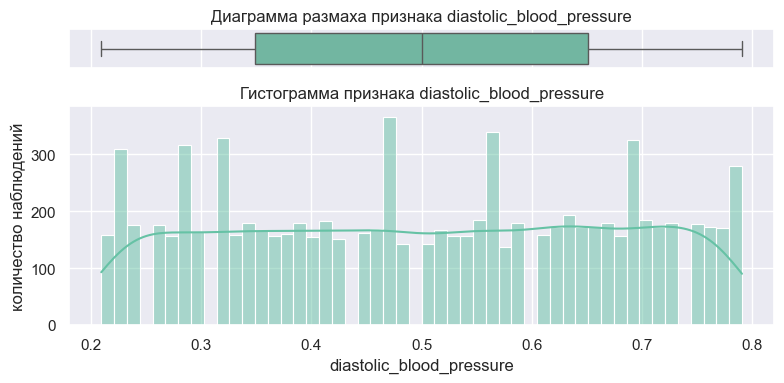

In [15]:
# применяем функцию к тренировочной выборке
for col in heart_train[num_columns]:
    eda_numeric(heart_train, col)

📌 **Выводы:**  

- признаки `age`/`cholesterol`/`exercise_hrs_week`/`sedentary_hrs_day`/`income`/`body_mass_idx`/`triglycerides`/
`systolic_blood_pressure`/`diastolic_blood_pressure`
    - непрерывные признаки, приведены к диапазону [0, 1] (вероятно, методом min-max scaling)
    - после предобработки потеряна интерпретируемость признаков в абсолютных величинах
    - распределение признаков выглядит близким к равномерному, что также может быть следствием предобработки данных
- признаки `blood_sugar`/`ck-mb`/`troponin`
    - непрерывный признак, приведённый к диапазону [0, 1] (вероятно, через min-max scaling)
    - по квантилям видно, что 25%, 50% и 75% наблюдений не просто близки, а имеют одно и то же значение — т.е. большая часть данных равны фиксированному значению (видимо, это закодированное значение нормы показателей)
    - остальные значения формируют длинный правый хвост распределения с выбросами до 1.0 - это указывает на относительно редкие, но выраженные отклонения от «нормы»     
- `heart_rate`
    - непрерывный признак, прошедший предварительное масштабирование (значения находятся в узком диапазоне ≈ [0.018; 0.082])
    - после масштабирования потеряна интерпретируемость признака: нельзя сказать, какая именно ЧСС соответствует конкретному значению
    - распределение признака выглядит близким к равномерному, что также может быть следствием предобработки данных
- `diet_type`
    - дискретный признак, 3 уникальных значения
    - наблюдения распределены практически поровну, немного преобладает тип '1'
- `stress_level`
    - дискретный признак с диапазоном значений от 1 до 10 
    - распределение почти равномерное: количество наблюдений по каждой категории отличается незначительно
- `physical_activity_days_week`
    - дискретный признак, значения от 0 до 7 
    - распределение наблюдений близко к равномерному, без выраженных перекосов
- `sleep_hrs_day`
    - дискретный признак, приведённый к диапазону [0, 1] (вероятно, через min-max scaling)
    - в исходных данных он отражал количество часов сна в сутки (от 0 до 7 часов), после масштабирования значения стали дробными долями
    - распределение признака достаточно равномерное
- признаки `family_history`/`obesity`/`prev_heart_problems`/`medication`
    - бинарные дискретные признаки
    - распределение примерно 50 / 50
- `diabetes`
    - бинарный дискретный признак
    - распределение неравномерное, диабет наблюдается у ~65% пациентов в выборке
- `smoking`
    - бинарный дискретный признак
    - распределение неравномерное, ~90% пациентов в выборке курят
- `alcohol`
    - бинарный дискретный признак
    - распределение неравномерное, ~60% пациентов в выборке употребляют алкоголь
- `gender`
    - бинарный дискретный признак
    - распределение неравномерное, ~70% пациентов в выборке - мужчины
- `heart_attack_risk`(таргет)
    - бинарный дискретный признак
    - распределение неравномерное, высокий риск наблюдается у ~35% пациентов в выборке
 
**Итог:** для моделей машинного обучения текущее представление признаков корректно и пригодно к использованию без дополнительных трансформаций (кодирование и масштабирование уже проведены), однако для анализа распределений показателей такие данные малоинформативны

<a id='4_correlative_analysis'></a>
## Корреляционный анализ

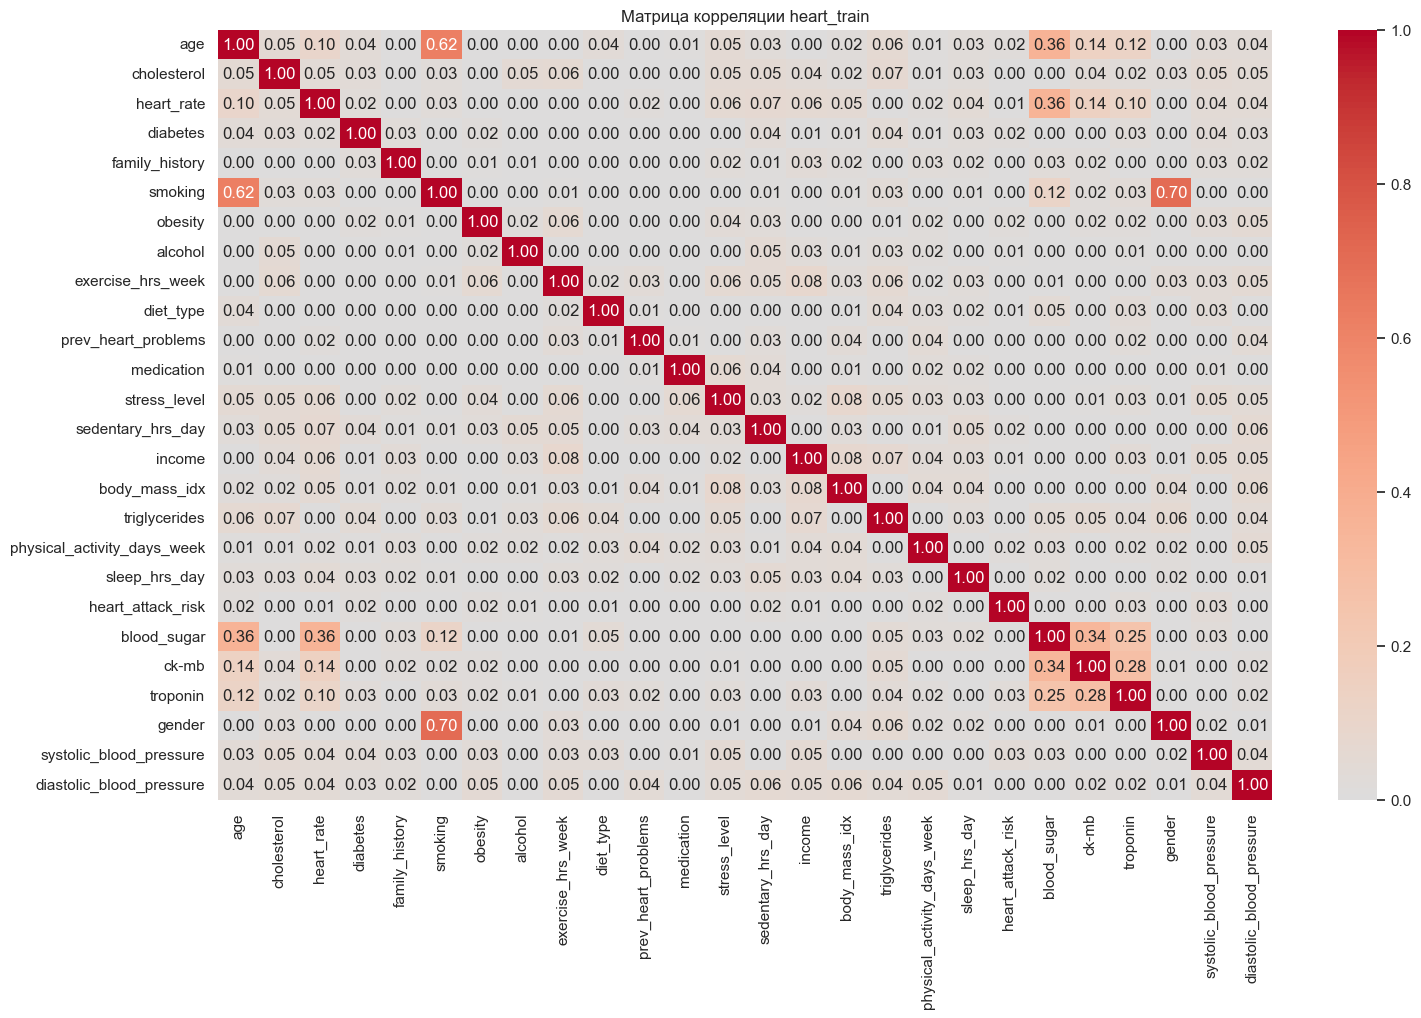

In [16]:
# построим корреляционную матрицу и тепловую карту для тренировочной выборки
corr_matrix_train = heart_train.phik_matrix(interval_cols=[
    'age', 'cholesterol', 'heart_rate', 'exercise_hrs_week', 'sedentary_hrs_day',
    'income', 'body_mass_idx', 'triglycerides', 'physical_activity_days_week',
    'sleep_hrs_day', 'blood_sugar', 'ck-mb', 'troponin', 'systolic_blood_pressure', 
    'diastolic_blood_pressure'
])

plt.figure(figsize=(17, 10))
sns.heatmap(corr_matrix_train, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title('Матрица корреляции heart_train')
plt.show()

📌 **Выводы:**  
- большинство коэффициентов корреляции находятся в диапазоне < 0.2 и практически несущественны  
- при этом, есть несколько коэффициентов, на которые стоит обратить внимание:  
    - `smoking ↔ gender`: 0.70 — в представленном датасете мужчины в чаще курят  
    - `age ↔ smoking`: 0.62 — более старшие пациенты чаще курят  
    - `age ↔ blood_sugar`: 0.36 — с возрастом уровень сахара в крови растёт
    - `heart_rate ↔ blood_sugar`: 0.36 — учащённый пульс чаще встречается при повышенном сахаре
    - `blood_sugar ↔ ck-mb`: r = 0.34 — оба биомаркёра могут сигнализировать о патологиях сердца
    
**Итог:** корреляционный анализ показал, что большинство коэффициентов связи между признаками низкие (< 0.2), а отдельные значения средней силы (до 0.7), однако для выбора направлений дальнейшей работы важно учитывать не только сами коэффициенты, но и смысловые взаимосвязи между показателями.  

<a id='5_new_features'></a>
## Добавление новых входных признаков

Результаты корреляционного анализа показали, что статистическая зависимость между отдельными признаками выражена слабо. Однако в медицинских данных низкие значения коэффициентов матрицы `phik` не всегда означают полное отсутствие взаимосвязи: параметры могут быть связаны опосредованно или через скрытые факторы.  

Кроме того, на этапе исследовательского анализаи можно было заметить, что распределения некоторых признаков имеют схожий характер. Такая «похожесть профиля» говорит о том, что признаки могут относиться к одной смысловой группе, даже если корреляция между ними не достигает высоких значений.  

Поэтому при построении новых признаков мы будем ориентироваться не только на коэффициенты корреляции, но и на смысловую близость и форму распределений, что позволит объединить параметры в логические блоки. Эти блоки будут отражать основные группы факторов риска (образ жизни, метаболические нарушения, кардиомаркёры и наследственность), помогут модели улавливать более сложные зависимости и повысить интерпретируемость.  

Можно добавить ниже перечисленные новые признаки по смысловым блокам:  

1. Кардиометаболический блок
- `bmi_age_interaction = body_mass_idx * age`  
→ произведение индекса массы тела на возраст (выявляет синергетический эффект массы и возраста)
- `diabetes_obesity = diabetes * obesity`  
→ комбинированный риск-фактор (отмечает комбинацию двух сильных факторов риска; помогает модели учитывать метаболический риск)
- `pulse_blood_pressure = systolic_blood_pressure - diastolic_blood_pressure`  
→ пульсовое давление (важный предиктор сердечно-сосудистых заболеваний)

2. Биомаркеры крови, анамнез
- `cardiac_marker_idx = ck-mb + troponin`  
→ объединённый показатель повреждения миокарда (усиливает точность предсказания инфаркта)
- `cardio_history_scaled = (prev_heart_problems + medication) / 2`  
→ прогностический сигнал на основе истории пациента (0 - низкий риск: нет истории сердечно-сосудистых проблем и не принимает лекарства; 1 - высокий риск)

3. Индексы образа жизни  
- `activity_balance_scaled = (physical_activity_days_week  / 7 − sedentary_hrs_day + 1) / 2`  
→ баланс активности (0 - минимальная активность; 1 - максимальная) 
- `lifestyle_risk_scaled = (smoking + alcohol + (stress_level - 1)/9 - sleep_hrs_day + 1) / 3`  
→ интегральный индекс нагрузки (0 - низкий риск: не курит, не пьёт, низкий стресс, хороший сон; 
1 - высокий риск: курение, алкоголь, сильный стресс, мало сна)

In [17]:
# добавляем в датасеты столбцы с новыми признаками
for df in [heart_train, heart_test]:
    df['bmi_age_interaction'] = df['body_mass_idx'] * df['age']
    df['diabetes_obesity'] = df['diabetes'] * df['obesity']
    df['pulse_blood_pressure'] = df['systolic_blood_pressure'] - df['diastolic_blood_pressure']
    df['cardiac_marker_idx'] = df['ck-mb'] + df['troponin']
    df['cardio_history_scaled'] = (df['prev_heart_problems'] + df['medication']) / 2
    df['activity_balance_scaled'] = (df['physical_activity_days_week'] / 7 - df['sedentary_hrs_day'] + 1) / 2
    df['lifestyle_risk_scaled'] = (
        df['smoking'] + df['alcohol'] + (df['stress_level'] - 1) / 9 - df['sleep_hrs_day']
    ) / 3

**Итог:** признаки `bmi_age_interaction`, `diabetes_obesity`, `pulse_blood_pressure`, `cardiac_marker_idx`, `cardio_history_scaled`, `activity_balance_scaled`, `lifestyle_risk_scaled` добавлены к входным признакам в тренировочную и тестовую выборки.

<a id='6_model_training'></a>
## Обучение моделей

### Пайплайн для обучения моделей

После расширения набора признаков модель получает возможность улавливать более сложные взаимодействия между факторами риска, которые не были видны при простом анализе отдельных переменных. Однако качество исходных данных остаётся ограниченным:
- коэффициенты `phik` указывают на слабые взаимосвязи между большинством признаков
- присутствуют шум и выбросы
- часть переменных несёт схожую информацию
  
В таких условиях при выборе моделей важно ориентироваться не только на статистические связи, но и на их способность работать с нелинейностями, опосредованными эффектами и зашумлёнными данными.

**Условия эксперимента:**  

- **Целевая переменная:** `heart_attack_risk` (категориальный бинарный признак)  
- **Тип задачи:** классификация (бинарная)  

- **Подготовка данных:**  

    - используются заранее масштабированные и закодированные данные
    - разделение выборки также выполнено заранее; тренировочная выборка содержит целевой признак, тестовая - нет

- **Модели:**  

    - базовая модель (baseline): `DecisionTreeClassifier`
    - ансамблевые модели:
        - `RandomForestClassifier`
        - `XGBClassifier`
        - `CatBoostClassifier`
    - подбор гиперпараметров с использованием `GridSearchCV`

- **Метрики:**
    - `ROC-AUC`
        - оценивает качество ранжирования вероятностей
        - чувствительна к дисбалансу классов
    - `F1`, `Fβ`
        - оценивают качество конкретных классификаций по порогу
        - нужны для интерпретации
        - `F1` - единый показатель качества модели, учитывающий в равной степени `precision` и `recall`
        - `Fβ` с `β=3` - показатель с усиленным приоритетом `recall`, что важно для минимизации пропуска пациентов с высоким риском (FN), но при этом не приводит к полной потере `precision`

In [18]:
# объявляем константы
RANDOM_STATE = 42

# разделяем таргет и входные признаки
X_train = heart_train.drop(columns=['heart_attack_risk'])
y_train = heart_train['heart_attack_risk']

# стратифицированная кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# модели и гиперпараметры
params = [
    # словарь для DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,7),
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 5],
    },
    # словарь для RandomForestClassifier
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)],
        'models__n_estimators': [100, 200, 500],
        'models__max_depth': [2, 5, 7],
        'models__min_samples_split': [2, 5],
        'models__class_weight': [None, 'balanced', 'balanced_subsample'],
    },
    # словарь для XGBoost
    {
        'models': [XGBClassifier(eval_metric='logloss', random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200],
        'models__max_depth': [3, 5, 7],
        'models__learning_rate': [0.05, 0.1],
        'models__scale_pos_weight': [round(sum(y_train == 0) / sum(y_train == 1), 2)],
    },
    # словарь для CatBoost
    {
        'models': [CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)],
        'models__iterations': [200, 400, 800],
        'models__depth': [4, 6, 8],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__l2_leaf_reg': [1, 3, 5],
        'models__class_weights': [[
            round(sum(y_train == 0) / len(y_train), 2), 
            round(sum(y_train == 1) / len(y_train), 2)
        ]],
    },
]

# метрики
scorers = {
    'roc_auc': 'roc_auc',
    'f1': make_scorer(f1_score),
    'f3': make_scorer(fbeta_score, beta=3),
}

# перебор моделей
pipe = Pipeline([
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE)) 
])

grid = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    scoring=scorers,
    refit='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)

# результаты
results = {
    'best_roc_auc': f"{grid.best_score_:.2f}",
    'best_f1': f"{grid.cv_results_['mean_test_f1'][grid.best_index_]:.2f}",
    'best_f3': f"{grid.cv_results_['mean_test_f3'][grid.best_index_]:.2f}",
    'best_params': grid.best_params_
}

print('Итоговые результаты:')
for key, value in results.items():
    print(f"{key}: {value}")

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Итоговые результаты:
best_roc_auc: 0.58
best_f1: 0.24
best_f3: 0.17
best_params: {'models': <catboost.core.CatBoostClassifier object at 0x146804c90>, 'models__class_weights': [0.64, 0.36], 'models__depth': 8, 'models__iterations': 800, 'models__l2_leaf_reg': 1, 'models__learning_rate': 0.1}


По итогам кросс-валидации лучше всего себя показала модель `CatBoostClassifier` с указанными выше гиперпараметрами. 

Метрики на тренировочных данных достаточно низкие, но, к сожалению, это лучший результат, которого удалось достичь в ходе эксперимента:  

- `ROC-AUC` = 0.58
- `F1-score` = 0.24
- `Fβ` = 0.17 (`β=3`)

Далее имеет смысл попробовать подобрать порог классификации, а также рассмотреть вклад отдельных входных признаков в модель.

### Подбор порога классификации

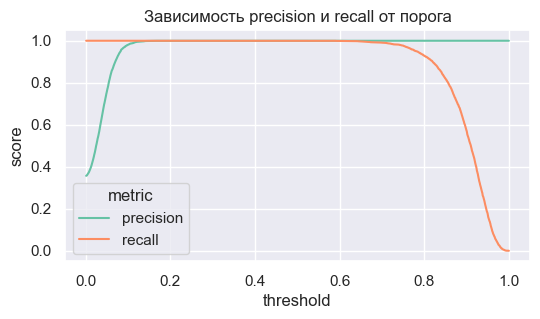

In [19]:
# вероятности положительного класса (высокий риск)
y_prob = grid.best_estimator_.predict_proba(X_train)[:, 1]

# вычисляем precision, recall и пороги
precision, recall, thresholds = precision_recall_curve(y_train, y_prob)

# thresholds возвращает len(thresholds) = len(precision)-1
thresholds = np.append(thresholds, 1.0)

df = pd.DataFrame({
    'threshold': np.tile(thresholds, 2),
    'score': np.concatenate([precision, recall]),
    'metric': ['precision']*len(thresholds) + ['recall']*len(thresholds)
})

plt.figure(figsize=(6,3))
sns.lineplot(data=df, x='threshold', y='score', hue='metric')
plt.title('Зависимость precision и recall от порога', fontsize=12)
plt.show()

На графике видно, что при практически любых порогах классификации `precision` и `recall` остаются близкими к 1 или очень высокими одновременно, т.е. модель уже прогнозирует высокий риск для большинства случаев. C точки зрения метрик качества, изменение порога здесь малоэффективно: оно не улучшит полноту выявления пациентов с высоким риском и не увеличит значимо точность, а значит, практической пользы от его подбора нет.

### Оценка важности признаков

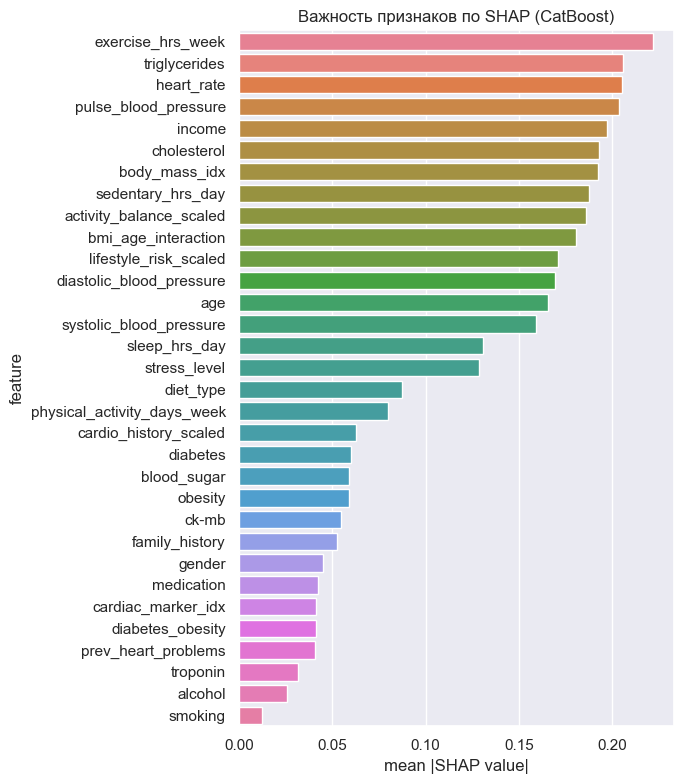

In [20]:
# модель
model = grid.best_estimator_.named_steps['models']

# создаём Pool с данными
pool = Pool(X_train, label=y_train)

# получаем shap_values
shap_values = model.get_feature_importance(pool, type='ShapValues')

base_values = shap_values[:, -1] # базовая вероятность класса 1 (base value)
shap_values = shap_values[:, :-1] # вклады отдельных признаков в смещение прогноза относительно base value

# считаем среднюю абсолютную важность каждого признака
feature_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)  

# строим график
plt.figure(figsize=(7,8))
sns.barplot(x='importance', y='feature', data=importance_df, hue ='feature', legend=False)
plt.xlabel('mean |SHAP value|')
plt.ylabel('feature')
plt.title('Важность признаков по SHAP (CatBoost)')
plt.tight_layout()
plt.show()

📌 **Выводы:**  
- судя по графику, лидирующие факторы — физическая активность, метаболические показатели (триглицериды, холестерин, индекс массы тела, пульсовое давление) → это согласутеся с медицинской практикой: именно эти группы признаков являются ключевыми предикторами сердечно-сосудистого риска
- композитные индексы (`bmi_age_interaction`, `lifestyle_risk_scaled`, `activity_balance_scaled`) также оказались значимыми → это подтверждает целесообразность добавления в модель этих признаков: модель действительно улавливает нелинейные и комбинированные эффекты
- не совем логично, но возраст, курение и алкоголь имеют относительно низкий вес → возможные причины:
    - влияние возраста частично «поглощено» через взаимодействия (`bmi_age_interaction`, `pulse_blood_pressure` и др.)
    - несбалансированность распределения по курению/алкоголю в выборке
    - обратная причинно-следственная связь (например, пациенты с выявленным высоким риском могли уже отказаться от курения)
- биомаркеры крови (тропонин, CK-MB) также оказались менее значимыми, чем ожидалось → это объяснимо, если предположить, что данные собраны в «спокойный» период (в рамках диспансеризации, например, а не во время инфаркта) - в таком случае маркеры действительно не так информативны для долгосрочного прогноза

### Сохранение лучшей модели

In [21]:
# сохраняем модель для использования вне ноутбука
joblib.dump(model, '../models/catboost_model.pkl')

['../models/catboost_model.pkl']

<a id='7_predictions'></a>
## Предсказание на тестовой выборке

In [22]:
# DataFrame с предсказаниями модели на тестовой выборке
predictions = pd.DataFrame({
    'id': heart_test.index,
    'prediction': model.predict(heart_test).astype(int),
})

# сохраняем в CSV
predictions.to_csv('../predictions.csv')

<a id='8_final'></a>
## Итоговые выводы

**Задача проекта:** разработать модель машинного обучения, которая сможет предсказать риск сердечного приступа (высокий / низкий) - *задача бинарной классификации*  

**Исходные данные, предобработка и подготовка:**  
  
- для работы были предоставлены 2 датасета (train / test) с данными пациентов
- данные были предобработаны: удалены служебные стобцы, столбцы переименованы и приведены к единому формату, строки с пропущенными значениями удалены (ок. 3% от каждой выборки), категориальный столбец с бинарным призаком `gender` приведён к числовому типу
- в датасеты были добавлены дополнительные признаки на основе комбинаций существующих признаков
- в рамках подготовки к обучению моделей дополнительных трансформаций данных не проводилось, т.к. датасеты изначально содержали масштабированные и закодированные признаки

**Поиск лучшей модели:**  

- Целевая переменная: `heart_attack_risk`  
- Модели:
    - базовая модель (baseline): `DecisionTreeClassifier`
    - ансамблевые модели:
        - `RandomForestClassifier`
        - `XGBoostClassifier`
        - `CatBoostClassifier`
    - подбор гиперпараметров с использованием `GridSearchCV`
- Метрики: `ROC-AUC`, `F1`, `Fβ`
  
- **Лучшая модель:** `CatBoostClassifier`
    - ROC-AUC (train): 0.58
    - F1-score (train): 0.24
    - Fβ-score (train, β=3): 0.17
      
- Анализ важности признаков (SHAP): наибольший вклад в предсказания модели вносят физическая активность `exercise_hrs_week`, метаболические показатели (`triglycerides`, `cholesterol`, `body_mass_idx`, `pulse_blood_pressure`), а также добавленные композитные индексы (`bmi_age_interaction`, `lifestyle_risk_scaled`, `activity_balance_scaled`)
  
- Предсказание на тестовой выборке: с использованием выбранной модели было подготовлено предсказание на тестовой выборке (изначально тестовый датасет был предоставлен без целевого признака)

📌 **Финальный вывод:**  

Результаты обучения показали, что в ходе экспериментов с различными комбинациями моделей / гиперпараметров / входных признаков получены катастрофически низкие значения метрик: `ROC-AUC` не поднимается выше значения 0.6, при этом `F-score` вообще стремится к 0, качество классификации остаётся на низком уровне даже для лучшей модели. Это означает, что модель лишь незначительно превосходит случайное угадывание и пока не может быть использована как надёжный инструмент диагностики.  

Тем не менее, важно отметить, что такие результаты напрямую связаны с качеством исходных данных:
- признаки были заранее масштабированы и закодированы, но содержали значительный шум и слабую взаимосвязь с целевой переменной
- часть медицинских показателей имела узкие диапазоны и искусственные распределения (например, биомаркеры крови с дисбалансом в значениях), что ограничивает способность модели улавливать закономерности
- анализ важности признаков показал, что модель в целом опирается на логически обоснованные факторы риска, однако этого оказалось недостаточно для точного предсказания

Таким образом, низкие метрики не свидетельствуют о полной бесполезности подхода, а скорее отражают ограничения датасета. Для повышения качества модели в будущем потребуется:
- собрать более детализированные и сбалансированные медицинские данные
- учесть изменения показателей со временем
- рассмотреть дополнительные источники признаков (ЭКГ-сигналы, образ жизни, наследственные факторы)

В текущем виде модель можно рассматривать как базовый прототип, демонстрирующий логику построения и возможность автоматизации анализа, но не как инструмент для практического применения в медицине.